In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error



In [12]:
path = '/Users/sheenmccullough/Documents/Kaggle/M5Forecasting/'

calendar = pd.read_csv(path+'calendar.csv')
trainData = pd.read_csv(path+'sales_train_validation.csv')
sellprices = pd.read_csv(path+'sell_prices.csv')

In [13]:
d_cols = [c for c in trainData.columns if 'd_' in c]
d_cols

['d_1',
 'd_2',
 'd_3',
 'd_4',
 'd_5',
 'd_6',
 'd_7',
 'd_8',
 'd_9',
 'd_10',
 'd_11',
 'd_12',
 'd_13',
 'd_14',
 'd_15',
 'd_16',
 'd_17',
 'd_18',
 'd_19',
 'd_20',
 'd_21',
 'd_22',
 'd_23',
 'd_24',
 'd_25',
 'd_26',
 'd_27',
 'd_28',
 'd_29',
 'd_30',
 'd_31',
 'd_32',
 'd_33',
 'd_34',
 'd_35',
 'd_36',
 'd_37',
 'd_38',
 'd_39',
 'd_40',
 'd_41',
 'd_42',
 'd_43',
 'd_44',
 'd_45',
 'd_46',
 'd_47',
 'd_48',
 'd_49',
 'd_50',
 'd_51',
 'd_52',
 'd_53',
 'd_54',
 'd_55',
 'd_56',
 'd_57',
 'd_58',
 'd_59',
 'd_60',
 'd_61',
 'd_62',
 'd_63',
 'd_64',
 'd_65',
 'd_66',
 'd_67',
 'd_68',
 'd_69',
 'd_70',
 'd_71',
 'd_72',
 'd_73',
 'd_74',
 'd_75',
 'd_76',
 'd_77',
 'd_78',
 'd_79',
 'd_80',
 'd_81',
 'd_82',
 'd_83',
 'd_84',
 'd_85',
 'd_86',
 'd_87',
 'd_88',
 'd_89',
 'd_90',
 'd_91',
 'd_92',
 'd_93',
 'd_94',
 'd_95',
 'd_96',
 'd_97',
 'd_98',
 'd_99',
 'd_100',
 'd_101',
 'd_102',
 'd_103',
 'd_104',
 'd_105',
 'd_106',
 'd_107',
 'd_108',
 'd_109',
 'd_110',
 'd_111'

In [16]:
ids = sorted(list(set(trainData['id'])))

x_1 = trainData.loc[trainData['id'] == ids[2]].set_index('id')[d_cols].values[0]
val_dataset = trainData[d_cols[-30:]]
val_dataset.head()

,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,1,1,1,0,0,0,0,0,1,0,...,1,3,0,1,1,1,3,0,1,1
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,2,1,2,1,1,1,0,1,1,1
3,6,6,0,0,0,0,3,1,2,1,...,1,0,5,4,1,0,1,3,7,2
4,0,0,1,0,4,4,0,1,4,0,...,2,1,1,0,1,1,2,2,2,4


In [18]:
len(val_dataset.columns)

30

In [3]:
def Convert_to_transaction(df):
    
    '''
    convert our sales data into a daily transacitons set using the pandas melt function
    '''
    list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
    d_columns = df.drop(list_id_vars,axis=1)
    df_melted_sales = df.melt(id_vars = list_id_vars, value_vars = d_columns.columns, var_name = 'days', value_name = 'sales') 
    
    
    return df_melted_sales



In [4]:
# This usually takes 16-19 sec to run

train_df_melt = Convert_to_transaction(trainData)

In [5]:
#del train_df_melt
del trainData
gc.collect()

144

In [6]:
train_df_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
train_df = pd.merge(train_df_melt,calendar[['d','wday','wm_yr_wk','event_name_1','date','year']],left_on='days',
                    right_on='d')

In [8]:
texas = train_df[train_df['state_id']=='TX']

In [9]:
del texas

In [ ]:
daily_sales = texas.groupby(['date'])['sales'].sum()

### basic time series equation

$$ Sales_{t+1} = f(Sales_t,Sales_{t-1},Sales_{t-2},Sales_{t-3}....,error), $$
#### Where t+1 is the next day and t-1 is the previous day. T-2 is two days prior and so on..This simplistic model's future prediction is only based on past sales values, but not on any external variables which might affect sales. The error term on the right allows for random variation

In [ ]:
## texas daily sales
plt.title('Texas Daily Sales')
daily_sales.plot(style='k.',figsize=(18,10))
plt.xticks(rotation='vertical')
plt.show()


## seasonal plot

In [ ]:
def seasonalplot(df):
    
    data=df[['year','date','sales']]
    unique_yrs = list(data['year'].drop_duplicates())
    for y in unique_yrs:
        yr_df = data[data['year']==y]
        yr_df['Month'] =pd.DatetimeIndex( yr_df['date']).month
        grpd = yr_df.groupby(['Month'])['sales'].sum()
        grpd.plot(figsize=(18,10))
    
    plt.legend(unique_yrs,fontsize=12,loc='upper left')
    plt.show()
    
        
    

In [ ]:
seasonalplot(texas)

In [ ]:
def subseriesboxplot(df):
    data=df[['year','date','sales']]
    dfgr = data.groupby(['date'])['sales'].sum().reset_index()
    dfgr['month'] = pd.DatetimeIndex(dfgr['date']).month
    
    plt.figure(figsize=(18,10))
    ax = sns.boxplot(x='month',y='sales',data=dfgr)
    print(dfgr['sales'].describe())
    
    

In [ ]:
subseriesboxplot(texas)

In [ ]:
def scatterbyday(df):
    data=df[['year','date','sales']]
    data['dayofyear'] = pd.DatetimeIndex(data['date']).dayofyear
    
    for y in list(data['year'].drop_duplicates()):
        dfgr = data[data['year']==y]
        dfgr = dfgr.groupby(['dayofyear'])['sales'].sum()
        dfgr.plot(figsize=(18,10))
    plt.legend(list(data['year'].drop_duplicates()),fontsize=12,loc='upper left')
    plt.show()
    
    dayofyear = data.groupby(['dayofyear'])['sales'].sum()
    dayofyear.plot(figsize=(18,10))

In [ ]:
scatterbyday(texas)

## Autocorrelation

just as correlation emasures the extent of a linear relationship between two variables, the autocorrelation measures the linear relationship between lagged values of a time series. 

$$ rk = \frac {\sum^T_{t=k+1} (y_t - ybar) (y_{t-k}-ybar)}{\sum^T_{t=1}(y_t - ybar)^2} $$

In [ ]:
autcorr= texas.groupby(['date'])['sales'].sum().reset_index()

In [ ]:
def autocorrelation(x, n_lags):
    autocorrels = {'lags':[],'autocorrelation':[]}
    for l in range(1,n_lags):
        mean = x.mean()
        normarray = x[:-l]
        lagarray= x[l:]
        numerator = sum([((yt-mean)*(ytk-mean)) for yt,ytk in zip(normarray,lagarray)])
        denominator = sum([(yt-mean)**2 for yt in normarray])
        
        autocorrels['lags'].append(l)
        autocorrels['autocorrelation'].append(numerator/denominator)
        
        plt.vlines(l,0,(numerator/denominator))
         
    plt.plot(autocorrels['lags'],autocorrels['autocorrelation'],'bo')
    plt.hlines(0,0,n_lags+1)
    upperlimit = 2/np.sqrt(len(normarray))
    lowerlimit = -(2/np.sqrt(len(normarray)))
    plt.hlines(lowerlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.hlines(upperlimit,0,n_lags+1,colors='b',linestyles='dashed')
    plt.show()


    return autocorrels


In [ ]:
#### there appears to be a weekly seasonal component based on the autocorrelation graph. r5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday

In [ ]:

plt.figure(figsize=(30,10))
autocdf=autocorrelation(autcorr['sales'],n_lags=90)


plt.plot(autcorr['sales'])
plt.xlim(0,90)


print(

"There appears to be a weekly seasonal component based on the autocorrelation graph. \nR5,r6,r7 are higher than for other lags. These points are Friday, Saturday, and Sunday"
)

A slow decrease in the ACF as lags increase is due to an upward trend while a slow increase would be due to a 
downward trend. Our time series does not appear to have any sort of trend.

## Noise

For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. For a white noise series, we expect 95% of the spikes in the ACF to lie within  ±2/√T where  T is the length of the time series. It is common to plot these bounds on a graph of the ACF as seen above with the dashed blue lines. If one or more large spikes ar eoutside of these bounds, or if substantially more than 5% of the spikes are outside, then the series is probably not noise. 

## Simple Forecasting Methods

    1.) Average Method: Forecasts for all future values are euqal to the average of the historical data. 
    
$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$
    
    2.) Naiive method
    3.) Seasonal Naiive Method
    4.) Drift Method

In [ ]:
train_df.head()

In [ ]:
samplesub = pd.read_csv(path+'sample_submission.csv')

In [ ]:
averageforcast = train_df.groupby(['id'])['sales'].mean().reset_index()

In [10]:
train = train_df[train_df['date']<='2016-04-01']
validation = train_df[train_df['date']>'2016-04-01']

<br>

<br>

In [ ]:
def plotforecast(evaluate,train, graphtype='simple_average'):
    
    groupedevaldrft = evaluate.groupby(['date'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date'])['sales'].sum().reset_index()
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date')
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    
    
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['days']= pd.to_datetime(forecastdays['days'])
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
 
    


    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')

    stdv = grouped['residuals'].std()


    if graphtype == 'simple_average':
        grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt((1+(1/len(grouped))))
        grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt((1+(1/len(grouped))))

        grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt((1+(1/len(grouped))))
        grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt((1+(1/len(grouped))))





        plt.figure(figsize=(18,5))

        plt.plot(trained['date'],trained['sales'])
        plt.plot(grouped['date'],grouped['sales'])
        plt.plot(grouped['date'],grouped['predictedsales'])

        plt.plot(grouped['date'],grouped['upper95'],'b')
        plt.plot(grouped['date'],grouped['lower95'],'b')
        plt.plot(grouped['date'],grouped['upper80'],'b--',)
        plt.plot(grouped['date'],grouped['lower80'],'b--')

        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['upper80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['lower80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['upper80'], 
                         grouped['upper95'], color='grey', alpha='0.3')


        plt.fill_between(grouped['date'], 
                         grouped['lower80'], 
                         grouped['lower95'], color='grey', alpha='0.3')




        plt.xlim('2016-01-01','2016-04-26')
        plt.show()

    elif graphtype =='naiive':
        grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt(grouped['h'])
        grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt(grouped['h'])

        grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt(grouped['h'])
        grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt(grouped['h'])





        plt.figure(figsize=(18,5))

        plt.plot(trained['date'],trained['sales'])
        plt.plot(grouped['date'],grouped['sales'])
        plt.plot(grouped['date'],grouped['predictedsales'])

        plt.plot(grouped['date'],grouped['upper95'],'b')
        plt.plot(grouped['date'],grouped['lower95'],'b')
        plt.plot(grouped['date'],grouped['upper80'],'b--',)
        plt.plot(grouped['date'],grouped['lower80'],'b--')

        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['upper80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['predictedsales'], 
                         grouped['lower80'], color='grey', alpha='0.5')


        plt.fill_between(grouped['date'], 
                         grouped['upper80'], 
                         grouped['upper95'], color='grey', alpha='0.3')


        plt.fill_between(grouped['date'], 
                         grouped['lower80'], 
                         grouped['lower95'], color='grey', alpha='0.3')




        plt.xlim('2016-01-01','2016-04-26')
    

Simple Average

$$ yhat_{T+h|T} = ybar = (y_1+....+y_T)/T $$



In [ ]:

def simplemean(train,validation):
    simplemean = train.groupby(['id'])['sales'].mean().reset_index()
    simplemean.columns= ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],simplemean,on='id')
    evaluate['residuals'] = evaluate['sales']-evaluate['predictedsales']
 
    
  
    
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    print("RMSE is {}".format(rmse))
    
    #plotforecast(evaluate,train,graphtype='simple_average')
    
    

    return rmse


In [ ]:
simplemean(train,validation)

$$ Naiive Method $$
$$ yhat_{T+h|T}=y_T $$

#simply set all forecasts to be the value of the last observation

In [24]:
x1 = train[train['id']=='HOBBIES_1_002_CA_1_validation']
v1 = validation[validation['id']=='HOBBIES_1_002_CA_1_validation']




In [ ]:
def naiveforecast(train,validation):
    maxdate = train['date'].max()
    maxdatedf = train[train['date']==maxdate]
    maxdatedf=maxdatedf[['id','sales']]
    maxdatedf.columns = ['id','predictedsales']
    evaluate = pd.merge(validation[['id','sales','date']],maxdatedf,on='id')
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    
    print("RMSE is {}".format(rmse))
    #plotforecast(evaluate,train,graphtype='naiive')
   
    return rmse

In [ ]:
naiveforecast(train,validation)

## Moving Average

$$ yhat_{T+h|T} = \frac{1}{d} * \sum^T_{T-d}y_n $$

In [51]:
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales,d,wday,wm_yr_wk,event_name_1,date,year
57626100,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,0,d_1891,1,11610,NaN,2016-04-02,2016
57626101,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,0,d_1891,1,11610,NaN,2016-04-02,2016
57626102,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,0,d_1891,1,11610,NaN,2016-04-02,2016
57626103,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,1,d_1891,1,11610,NaN,2016-04-02,2016
57626104,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,1,d_1891,1,11610,NaN,2016-04-02,2016


In [93]:
def MAPred(train,validation,id_,MA=90):

    x1 = train[train['id']==id_]
    v1 = validation[validation['id']==id_]


    

    predictions = []
    for i in range(len(v1)):
        if i ==0:
            pred = np.mean(x1['sales'][-MA:])
            predictions.append(pred)

        elif i < MA+1 and i > 0:

            pred = .5* (np.mean(x1['sales'][-MA+i:]) + np.mean(predictions[:i]))
            predictions.append(pred)
        elif i > MA+1:

            predictions.append(np.mean(predictions[:i]))
            
            
    v1['predictionMA'] = predictions
    return v1


  

In [94]:
def RunMA(train,validation):
    
    preds = []
    uniqueids = list(train['id'].drop_duplicates())
    for id_ in uniqueids:
        MAPred()

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [95]:

valpred

,id,item_id,dept_id,cat_id,store_id,state_id,days,sales,d,wday,wm_yr_wk,event_name_1,date,year,predictionMA
57626107,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1891,38,d_1891,1,11610,NaN,2016-04-02,2016,10.100000
57656597,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1892,22,d_1892,2,11610,NaN,2016-04-03,2016,10.117416
57687087,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1893,2,d_1893,3,11610,NaN,2016-04-04,2016,10.167990
57717577,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1894,0,d_1894,4,11610,NaN,2016-04-05,2016,10.230901
57748067,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1895,10,d_1895,5,11610,NaN,2016-04-06,2016,10.292155
57778557,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1896,26,d_1896,6,11610,NaN,2016-04-07,2016,9.926140
57809047,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1897,8,d_1897,7,11610,NaN,2016-04-08,2016,9.914788
57839537,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1898,12,d_1898,1,11611,NaN,2016-04-09,2016,9.866781
57870027,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1899,4,d_1899,2,11611,NaN,2016-04-10,2016,9.904364
57900517,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1900,5,d_1900,3,11611,NaN,2016-04-11,2016,9.849906


In [66]:
x1['sales'][len(x1)-89:len(x1)]



54912497     2
54942987     1
54973477     2
55003967    75
55034457     8
55064947    15
55095437     1
55125927    17
55156417     5
55186907     8
55217397    18
55247887     6
55278377    47
55308867     5
55339357    48
55369847     4
55400337    16
55430827    13
55461317    13
55491807    14
55522297     4
55552787     3
55583277     0
55613767     8
55644257     1
55674747     1
55705237    23
55735727    12
55766217     4
55796707     5
            ..
56711407     0
56741897     0
56772387     0
56802877     0
56833367     0
56863857     4
56894347    27
56924837     1
56955327     2
56985817    19
57016307    28
57046797     3
57077287     1
57107777     2
57138267     0
57168757    17
57199247    11
57229737     0
57260227     2
57290717    13
57321207    10
57351697     2
57382187     0
57412677     0
57443167     0
57473657     0
57504147    11
57534637     5
57565127     2
57595617    12
Name: sales, Length: 89, dtype: int64

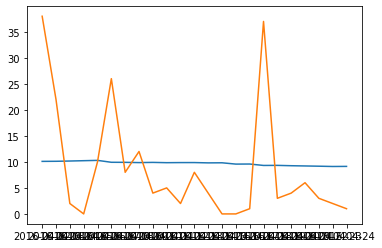

In [50]:
plt.plot(v1['date'],predictions)
plt.plot(v1['date'],v1['sales'])

plt.xlim('2016-01-01','2016-04-26')

We set each forecast to be equal to the last observation value from the same point on time of the year before

$$ Seasonal Naiive Method $$
$$ yhat_{T+h|T} = y_{T+h - m(k+1)} $$

Where m is the seasonal period and k is the ineger part of (h-1)/m 
With quarterly data, the forecast of all future Q2 values is equal to the last observed Q2

In [ ]:
def seasonalnaiveforecast(train,validation):
    validation['date']= pd.to_datetime(validation['date'])
    train['date']= pd.to_datetime(train['date'])


    validation = validation[['id','sales','date']]
    validation['t-1'] = validation['date']- pd.Timedelta(days=365) 
    seasonal = train[['id','date','sales']]
    seasonal.columns = ['id','date','predictedsales']
    evaluate = pd.merge(validation,seasonal,left_on=['id','t-1'],
                       right_on=['id','date'])
    rmse= np.sqrt(mean_squared_error(evaluate['sales'],evaluate['predictedsales']))
    print("RMSE is {}".format(rmse))
    
    
    forecastdays = pd.DataFrame({'days':validation['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]


    groupedevaldrft = evaluate.groupby(['date_x'])['predictedsales'].sum().reset_index()
    groupedevalsales = evaluate.groupby(['date_x'])['sales'].sum().reset_index()
    
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,on='date_x')

    grouped['residuals'] = grouped['sales']-grouped['predictedsales']
    
    grouped = pd.merge(grouped,forecastdays,left_on='date_x',right_on='days')
    


    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['predictedsales'] + (1.96*stdv) *np.sqrt((grouped['h']-1)/7)
    grouped['lower95'] = grouped['predictedsales'] - (1.96*stdv) *np.sqrt((grouped['h']-1)/7)
    grouped['upper80'] = grouped['predictedsales'] + (1.28*stdv)*np.sqrt((grouped['h']-1)/7)
    grouped['lower80'] = grouped['predictedsales'] - (1.28*stdv)*np.sqrt((grouped['h']-1)/7)
    
    
   
    plt.figure(figsize=(18,5))

    plt.plot(trained['date'],trained['sales'])
    
    
    
    plt.plot(grouped['date_x'],grouped['sales'])
    plt.plot(grouped['date_x'],grouped['predictedsales'])
    
    plt.plot(grouped['date_x'],grouped['upper95'],'b')
    plt.plot(grouped['date_x'],grouped['lower95'],'b')
    plt.plot(grouped['date_x'],grouped['upper80'],'b--',)
    plt.plot(grouped['date_x'],grouped['lower80'],'b--')
    
    plt.xlim('2016-01-01','2016-04-26')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['predictedsales'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['predictedsales'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date_x'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date_x'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')




    plt.xlim('2016-01-01','2016-04-26')
    






    return rmse

In [ ]:
seasonalnaiveforecast(train,validation)

### Drift Method
    -A variation of the naiive method is to allow forecast to increase or decrease over time, where the amount
    
    of the change over time (the *drift*) is set to be the average change seen in the historical data.
    
$$ yhat_{T+h|T} = y_T + h\frac{y_t - y_1}{T - T_0}$$ 

In [ ]:

def driftmethodforecast(train,validation):
    
    
    y_t_df = train[train['date']==train['date'].max()][['id','sales']]
    y_0_df = train[train['date']==train['date'].min()][['id','sales']]
    y_t_df.columns=['id','salesT']
    y_0_df.columns=['id','sales0']
    valcounts = train['id'].value_counts().reset_index()
    valcounts.columns=['id','counts']

    m_df = pd.merge(pd.merge(y_t_df,y_0_df,on='id'),valcounts,on='id')
    m_df['slope'] = (m_df['salesT']-m_df['sales0'])/m_df['counts']


    forecastdays = pd.DataFrame({'days':validation['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]

    evaluationdf = pd.merge(validation[['id','date','sales']],forecastdays,left_on='date',right_on='days')

    evaluationdf = pd.merge(evaluationdf,m_df,on='id')


    evaluationdf['drift_forecast'] = evaluationdf['salesT'] + (evaluationdf['slope'] * evaluationdf['h'])
    
    

    rmse= np.sqrt(mean_squared_error(evaluationdf['sales'],evaluationdf['drift_forecast']))

    print("RMSE is {}".format(rmse))



    groupedevaldrft = evaluationdf.groupby(['date'])['drift_forecast'].sum().reset_index()
    groupedevalsales = evaluationdf.groupby(['date'])['sales'].sum().reset_index()
    
    trained = train.groupby(['date'])['sales'].sum().reset_index()
    
    
 
    
    grouped = pd.merge(groupedevaldrft,groupedevalsales,left_on='date',right_on='date')
    
    
    grouped['residuals'] = grouped['sales']-grouped['drift_forecast']
    forecastdays = pd.DataFrame({'days':grouped['date'].drop_duplicates()})
    forecastdays['h'] = [(x-forecastdays['days'].min()).days for x in forecastdays['days']]
    
    grouped = pd.merge(grouped,forecastdays,left_on='date',right_on='days')

    
    stdv = grouped['residuals'].std()
    
    grouped['upper95'] = grouped['drift_forecast'] + (1.96*stdv) *np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    grouped['lower95'] = grouped['drift_forecast'] - (1.96*stdv) *np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    
    grouped['upper80'] = grouped['drift_forecast'] + (1.28*stdv)*np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    grouped['lower80'] = grouped['drift_forecast'] - (1.28*stdv)*np.sqrt(grouped['h']*(1+(grouped['h']/len(grouped))))
    

    plt.figure(figsize=(18,5))
    plt.plot(grouped['date'],grouped['sales'])
    plt.plot(trained['date'],trained['sales'])
    plt.plot(grouped['date'],grouped['drift_forecast'])
    
    
    
    plt.plot(grouped['date'],grouped['upper95'],'b')
    plt.plot(grouped['date'],grouped['lower95'],'b')
    plt.plot(grouped['date'],grouped['upper80'],'b--',)
    plt.plot(grouped['date'],grouped['lower80'],'b--')
    
    plt.fill_between(grouped['date'], 
                     grouped['drift_forecast'], 
                     grouped['upper80'], color='grey', alpha='0.5')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['drift_forecast'], 
                     grouped['lower80'], color='grey', alpha='0.5')


    plt.fill_between(grouped['date'], 
                     grouped['upper80'], 
                     grouped['upper95'], color='grey', alpha='0.3')
    
    
    plt.fill_between(grouped['date'], 
                     grouped['lower80'], 
                     grouped['lower95'], color='grey', alpha='0.3')





    plt.xlim('2016-01-01','2016-04-26')




    
    return rmse

In [ ]:
driftmethodforecast(train,validation)